In [206]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt ;
import seaborn as sns;
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Import DataSet

In [207]:
train_data = pd.read_csv('train.csv');
test_data = pd.read_csv('test.csv');

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Explorartory Data Analysis & Data Pre-Processing

In [208]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [209]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [210]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [211]:
# Fill Missing values

train_data['Age'].fillna(train_data['Age'].median(),inplace = True);

train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace = True)

In [212]:
# Cabin, Ticket and Name columns are not useful to predict the survival, hence we can drop the columns.

train_data.drop(columns = ['Cabin','Ticket','Name'], inplace = True)

In [213]:
train_data['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

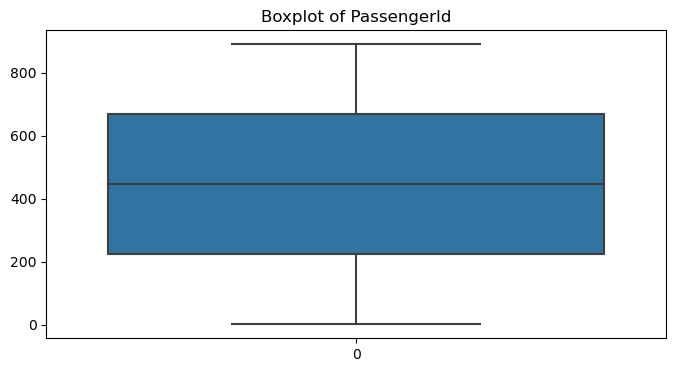

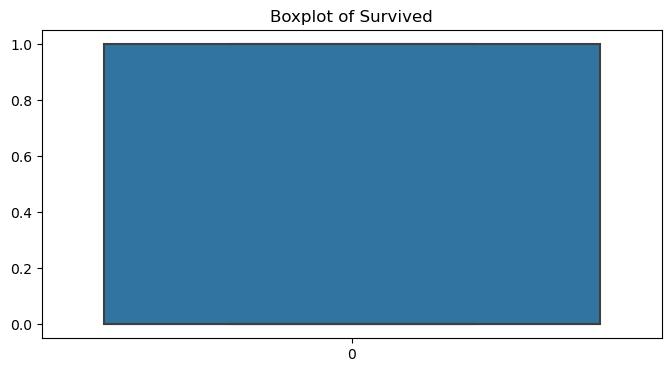

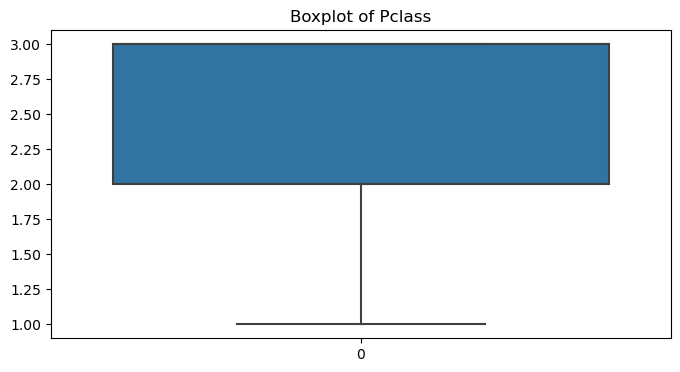

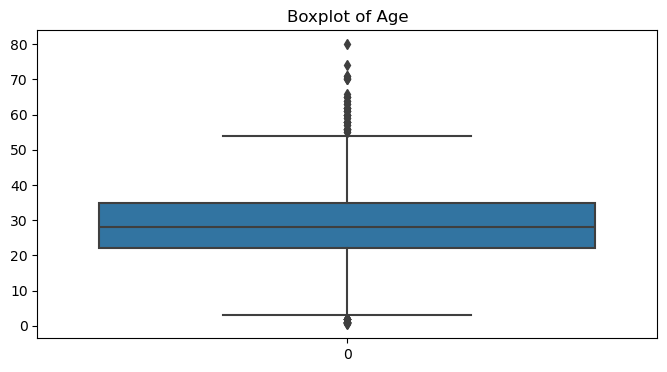

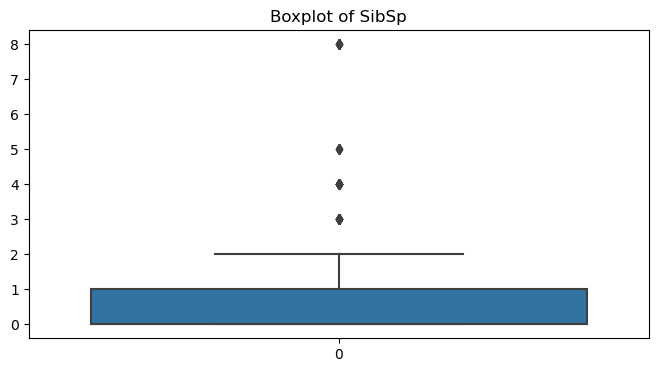

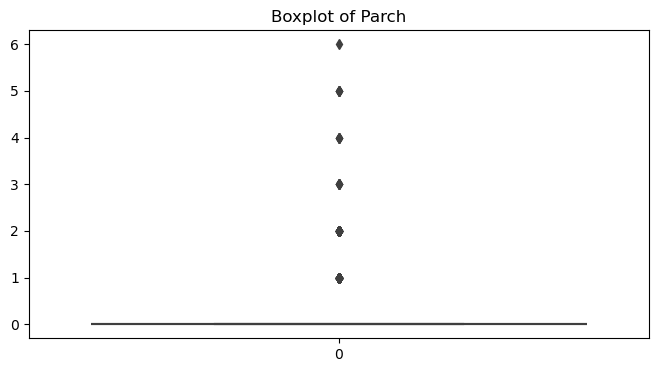

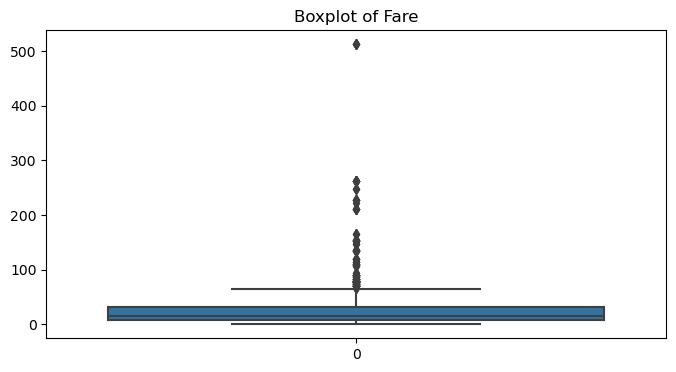

In [214]:
#checking the outliers:

numeric_columns = train_data.select_dtypes(include = ['float64','int64']).columns

for col in numeric_columns:
    plt.figure(figsize = (8,4))
    sns.boxplot(train_data[col])
    plt.title(f'Boxplot of {col}');
    plt.show()

In [215]:
# Age, SibSp,Parch,Fare has outliers

In [216]:
# IQR Method :

Q1 = train_data[numeric_columns].quantile(0.25)
Q3 = train_data[numeric_columns].quantile(0.75)

IQR = Q3-Q1

lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

outliers_iqr = ((train_data[numeric_columns] < lower_bound) | (train_data[numeric_columns] > upper_bound))

outliers_iqr.sum()

PassengerId      0
Survived         0
Pclass           0
Age             66
SibSp           46
Parch          213
Fare           116
dtype: int64

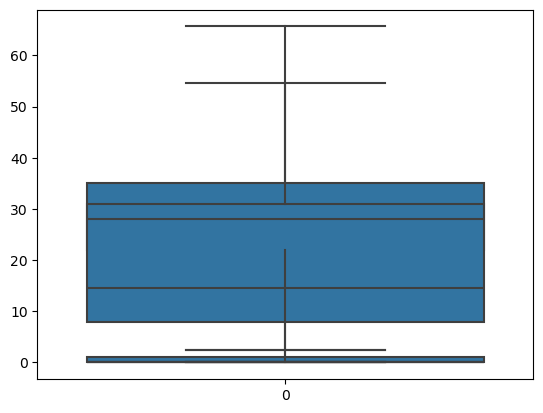

In [217]:
# Capping method to keep the outliers.

def cap_outliers(df,column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    df[column] = df[column].apply(lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x))

    return df[column]

columns_with_outliers = ['Age','SibSp','Parch','Fare'];

for col in columns_with_outliers:
    train_data[col] = cap_outliers(train_data,col)

sns.boxplot(data=train_data['Age'])
sns.boxplot(data=train_data['SibSp'])
sns.boxplot(data=train_data['Parch'])
sns.boxplot(data=train_data['Fare'])
plt.show()

In [218]:
print(train_data.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked'],
      dtype='object')


In [219]:
# Convert categorical variables (Sex,Embarked) into dummy variable

train_data = pd.get_dummies(train_data, columns=['Sex','Embarked'], drop_first = True)

train_data.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,1,0,3,22.0,1.0,0.0,7.2500,True,False,True
1,2,1,1,38.0,1.0,0.0,65.6344,False,False,False
2,3,1,3,26.0,0.0,0.0,7.9250,False,False,True
3,4,1,1,35.0,1.0,0.0,53.1000,False,False,True
4,5,0,3,35.0,0.0,0.0,8.0500,True,False,True


# Building the Model:

In [220]:
# Separate fetaure and target variable

X = train_data.drop(['Survived'], axis = 1)
Y = train_data['Survived']

In [221]:
# Splitting the training data into train and validation sets

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2, random_state = 42)

In [222]:
model = LogisticRegression()

model.fit(X_train,Y_train)

C:\Users\prana\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [223]:
Y_pred = model.predict(X_test)

In [224]:
print('Accuracy Score:', accuracy_score(Y_test,Y_pred))

Accuracy Score: 0.7821229050279329


In [225]:
print('Confusion Matrix:\n',confusion_matrix(Y_test, Y_pred))

Confusion Matrix:
 [[86 19]
 [20 54]]


In [226]:
print('Classification Report:\n', classification_report(Y_test, Y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.82      0.82       105
           1       0.74      0.73      0.73        74

    accuracy                           0.78       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179



In [227]:
print(test_data.head())

   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  


In [228]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [229]:
test_data.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [230]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [231]:
# Fill Missing values

test_data['Age'].fillna(test_data['Age'].median(),inplace = True);

test_data['Fare'].fillna(test_data['Fare'].median(),inplace = True);


In [232]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64

In [233]:
test_data.drop(columns = ['Cabin','Ticket','Name'], inplace = True)

In [234]:
test_data.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,male,34.5,0,0,7.8292,Q
1,893,3,female,47.0,1,0,7.0000,S
2,894,2,male,62.0,0,0,9.6875,Q
3,895,3,male,27.0,0,0,8.6625,S
4,896,3,female,22.0,1,1,12.2875,S


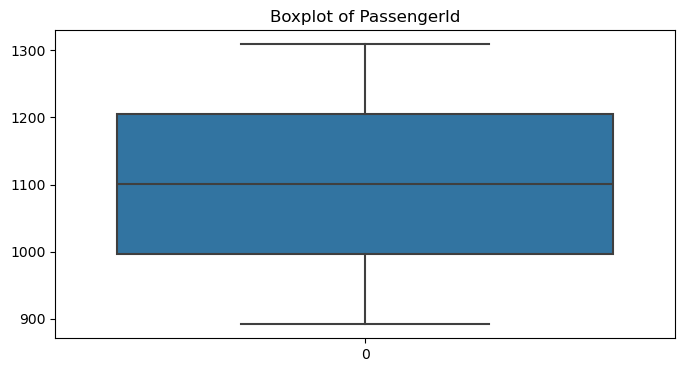

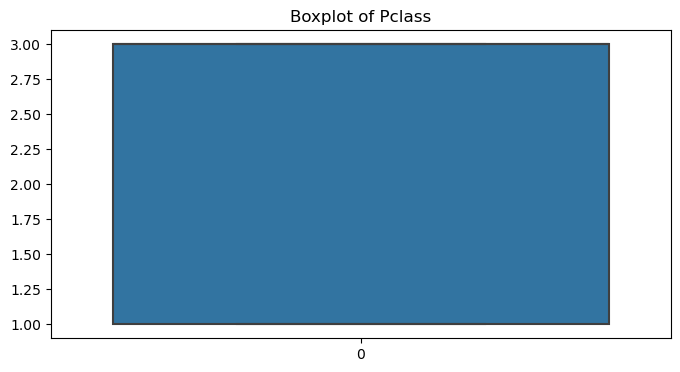

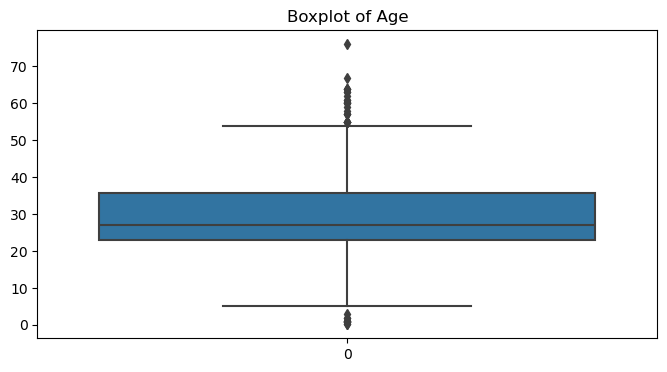

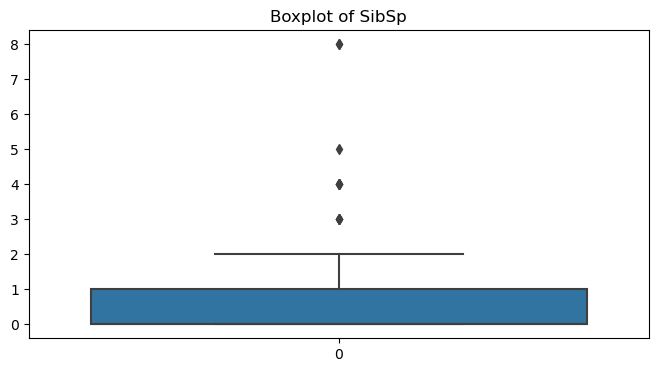

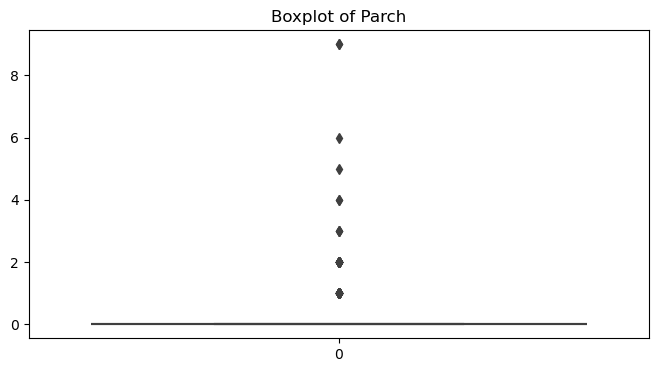

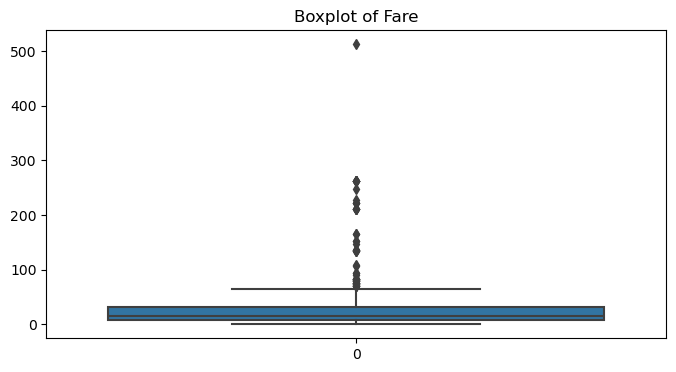

In [235]:
#checking the outliers:

numeric_columns_test = test_data.select_dtypes(include = ['float64','int64']).columns

for col in numeric_columns_test:
    plt.figure(figsize = (8,4))
    sns.boxplot(test_data[col])
    plt.title(f'Boxplot of {col}');
    plt.show()

In [236]:
# IQR Method :

Q1 = test_data[numeric_columns_test].quantile(0.25)
Q3 = test_data[numeric_columns_test].quantile(0.75)

IQR = Q3-Q1

lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

outliers_iqr = ((test_data[numeric_columns_test] < lower_bound) | (test_data[numeric_columns_test] > upper_bound))

outliers_iqr.sum()

PassengerId     0
Pclass          0
Age            36
SibSp          11
Parch          94
Fare           55
dtype: int64

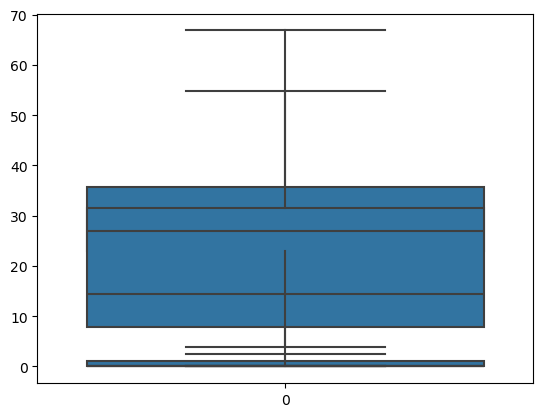

In [237]:
# Capping method to keep the outliers.

def cap_outliers_test(df,column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    df[column] = df[column].apply(lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x))

    return df[column]

columns_with_outliers_test = ['Age','SibSp','Parch','Fare'];

for col in columns_with_outliers_test:
    test_data[col] = cap_outliers_test(test_data,col)

sns.boxplot(data=test_data['Age'])
sns.boxplot(data=test_data['SibSp'])
sns.boxplot(data=test_data['Parch'])
sns.boxplot(data=test_data['Fare'])
plt.show()

In [238]:
# Convert categorical variables (Sex,Embarked) into dummy variable

test_data = pd.get_dummies(test_data, columns=['Sex','Embarked'], drop_first = True)

test_data.head()


,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,892,3,34.500,0.0,0.0,7.8292,True,True,False
1,893,3,47.000,1.0,0.0,7.0000,False,False,True
2,894,2,54.875,0.0,0.0,9.6875,True,True,False
3,895,3,27.000,0.0,0.0,8.6625,True,False,True
4,896,3,22.000,1.0,0.0,12.2875,False,False,True


In [245]:
print(test_data.shape)

(418, 9)


In [239]:
missing_cols = set(X_train.columns) - set(test_data.columns)
missing_cols

set()

In [248]:
# Assuming X_test is the processed test data
test_predictions = model.predict(test_data)


In [249]:
print(test_predictions.shape)  # Check the number of predictions matches test_data


(418,)


In [250]:
# Create a DataFrame for submission
submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],  # Make sure PassengerId is in test_data
    'Survived': test_predictions              # Predictions from your model
})

# Save the submission to a CSV file
submission.to_csv('submission.csv', index=False)

# Optional: Print the first few rows to check the format
print(submission.head())


   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1
